In [ ]:
!pip install torch torchvision matplotlib

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt

In [ ]:
# Define the VAE model
class VAE(nn.Module):
    def __init__(self, latent_dim):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28 * 28, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, latent_dim * 2)  # Output mean and log variance
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 28 * 28),
            nn.Sigmoid()
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        h = self.encoder(x)
        mu, logvar = h.chunk(2, dim=1)
        z = self.reparameterize(mu, logvar)
        return self.decoder(z), mu, logvar

# Loss function
def loss_function(recon_x, x, mu, logvar):
    BCE = nn.functional.binary_cross_entropy(recon_x, x.view(-1, 28 * 28), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

# Plot some images
def plot_images(images, title):
    plt.figure(figsize=(10, 4))
    for i in range(10):
        ax = plt.subplot(2, 10, i + 1)
        plt.imshow(images[i].view(28, 28), cmap='gray')
        plt.axis('off')
    plt.title(title)
    plt.show()


Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 17849743.26it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 486199.74it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 4388008.16it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 3738329.82it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



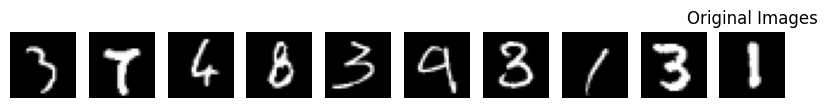

In [ ]:
# Load MNIST dataset
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=128, shuffle=True)

# Display original images
original_images = next(iter(train_loader))[0]
plot_images(original_images, title="Original Images")

In [ ]:
# Set device, model, optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
latent_dim = 2
model = VAE(latent_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
model.load_state_dict(torch.load('vae.pth', weights_only=True))

<All keys matched successfully>

In [30]:
# Train the VAE
model.train()
num_epochs = 50
for epoch in range(num_epochs):
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()

    if (epoch+1) % 10 == 0:
        print(f'Epoch {epoch+1}, Loss: {train_loss / len(train_loader.dataset)}')

torch.save(model.state_dict(), 'vae.pth')

Epoch 0, Loss: 134.54632819010416
Epoch 10, Loss: 134.24401822916667
Epoch 20, Loss: 134.46040854492188
Epoch 30, Loss: 134.1423045735677
Epoch 40, Loss: 134.02376547851563


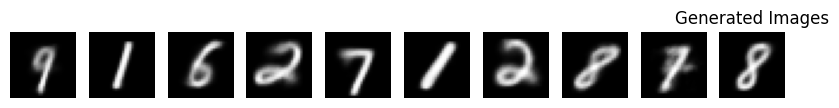

In [31]:
# Generate new digits
def generate_digits(model, num_samples):
    model.eval()
    with torch.no_grad():
        z = torch.randn(num_samples, latent_dim).to(device)
        generated_images = model.decoder(z).cpu()
    return generated_images



# Generate and display new images
generated_images = generate_digits(model, 10)
plot_images(generated_images, title="Generated Images")